# Solutions -- Tutorial 03: Forecast Error Variance Decomposition (FEVD)

This notebook contains **complete solutions** for the exercises in Tutorial 03 (FEVD Decomposition).

Each exercise is presented with:
1. The original problem statement
2. A complete, runnable code solution
3. Discussion and interpretation of results

**Prerequisites:** You should attempt the exercises in `notebooks/03_fevd_decomposition.ipynb` before consulting these solutions.

---

## Setup

The setup cell below is identical to the one in the tutorial notebook. It loads the required libraries, configures plotting, and prepares the Panel VAR model.

In [1]:
import sys
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
np.random.seed(42)
warnings.filterwarnings('ignore')

project_root = Path('../../../').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

sys.path.insert(0, '../utils')

from panelbox.var import PanelVARData, PanelVAR

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 100, 'font.size': 11})

print('Setup complete.')

Setup complete.


## Data Loading and Model Estimation

We load the macroeconomic panel dataset and estimate a VAR(2) model with three endogenous variables.

In [2]:
df = pd.read_csv('../data/macro_panel.csv')
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')

endog_vars = ['gdp_growth', 'inflation', 'interest_rate']
data = PanelVARData(df, endog_vars=endog_vars, entity_col='country', time_col='quarter', lags=2)
model = PanelVAR(data)
results = model.fit(method='ols', cov_type='clustered')
print(f"Model estimated: {endog_vars}, lags={data.p}")
print(f"Countries: {df['country'].nunique()}, Quarters: {df['quarter'].nunique()}")

Model estimated: ['gdp_growth', 'inflation', 'interest_rate'], lags=2
Countries: 30, Quarters: 40


---

## Exercise 1: Ordering Sensitivity in FEVD (Easy)

**Task:** Compute Cholesky FEVD with two different orderings and compare the decomposition of GDP growth variance at horizons h = 1, 5, 10, 20.

- **Ordering 1:** `['interest_rate', 'inflation', 'gdp_growth']` (monetary policy first)
- **Ordering 2:** `['gdp_growth', 'inflation', 'interest_rate']` (output first)

Discuss how sensitive the results are to the ordering and why Generalized FEVD might be preferred.

In [3]:
# -------------------------------------------------------
# Exercise 1 Solution: Ordering Sensitivity in FEVD
# -------------------------------------------------------

# Ordering 1: interest_rate -> inflation -> gdp_growth
order1 = ['interest_rate', 'inflation', 'gdp_growth']
fevd_order1 = results.fevd(periods=20, method='cholesky', order=order1)

# Ordering 2: gdp_growth -> inflation -> interest_rate
order2 = ['gdp_growth', 'inflation', 'interest_rate']
fevd_order2 = results.fevd(periods=20, method='cholesky', order=order2)

print('Ordering 1:', order1)
print('Ordering 2:', order2)
print()

# Horizons of interest
horizons = [1, 5, 10, 20]

Ordering 1: ['interest_rate', 'inflation', 'gdp_growth']
Ordering 2: ['gdp_growth', 'inflation', 'interest_rate']



In [4]:
# Extract GDP growth decomposition at key horizons for both orderings
gdp_idx_1 = fevd_order1.var_names.index('gdp_growth')
gdp_idx_2 = fevd_order2.var_names.index('gdp_growth')

rows = []
for h in horizons:
    row = {'Horizon': h}
    # Ordering 1
    for j, var in enumerate(fevd_order1.var_names):
        row[f'O1_{var}'] = fevd_order1.decomposition[h, gdp_idx_1, j]
    # Ordering 2
    for j, var in enumerate(fevd_order2.var_names):
        row[f'O2_{var}'] = fevd_order2.decomposition[h, gdp_idx_2, j]
    rows.append(row)

df_compare = pd.DataFrame(rows).set_index('Horizon')

# Display as percentages
print('FEVD of GDP Growth: Ordering Comparison')
print('=' * 90)
print(f"{'':>8} | {'--- Ordering 1 ---':^42} | {'--- Ordering 2 ---':^42}")
print(f"{'Horizon':>8} | ", end='')
for var in fevd_order1.var_names:
    print(f'{var:>14}', end='')
print(' | ', end='')
for var in fevd_order2.var_names:
    print(f'{var:>14}', end='')
print()
print('-' * 90)

for h in horizons:
    print(f'{h:>8} | ', end='')
    for j in range(len(fevd_order1.var_names)):
        val = fevd_order1.decomposition[h, gdp_idx_1, j] * 100
        print(f'{val:>13.2f}%', end='')
    print(' | ', end='')
    for j in range(len(fevd_order2.var_names)):
        val = fevd_order2.decomposition[h, gdp_idx_2, j] * 100
        print(f'{val:>13.2f}%', end='')
    print()

FEVD of GDP Growth: Ordering Comparison
         |             --- Ordering 1 ---             |             --- Ordering 2 ---            
 Horizon |  interest_rate     inflation    gdp_growth |     gdp_growth     inflation interest_rate
------------------------------------------------------------------------------------------
       1 |          1.64%         2.33%        96.03% |         98.17%         0.00%         1.83%
       5 |          8.20%         2.77%        89.03% |         90.80%         0.57%         8.62%
      10 |          8.35%         3.31%        88.34% |         90.22%         1.04%         8.74%
      20 |          8.36%         3.32%        88.32% |         90.21%         1.04%         8.75%


In [5]:
# Compute absolute differences between the two orderings at each horizon
print('\nAbsolute Differences (percentage points):')
print('=' * 60)
print(f"{'Horizon':>8} | ", end='')
for var in endog_vars:
    print(f'{var:>16}', end=' | ')
print()
print('-' * 60)

for h in horizons:
    print(f'{h:>8} | ', end='')
    for var in endog_vars:
        j1 = fevd_order1.var_names.index(var)
        j2 = fevd_order2.var_names.index(var)
        val1 = fevd_order1.decomposition[h, gdp_idx_1, j1] * 100
        val2 = fevd_order2.decomposition[h, gdp_idx_2, j2] * 100
        diff = abs(val1 - val2)
        print(f'{diff:>15.2f}pp', end=' | ')
    print()

# Compute max absolute difference across all horizons and shocks
max_diff = 0.0
for h in horizons:
    for var in endog_vars:
        j1 = fevd_order1.var_names.index(var)
        j2 = fevd_order2.var_names.index(var)
        val1 = fevd_order1.decomposition[h, gdp_idx_1, j1]
        val2 = fevd_order2.decomposition[h, gdp_idx_2, j2]
        max_diff = max(max_diff, abs(val1 - val2))

print(f'\nMaximum absolute difference: {max_diff * 100:.2f} percentage points')


Absolute Differences (percentage points):
 Horizon |       gdp_growth |        inflation |    interest_rate | 
------------------------------------------------------------
       1 |            2.14pp |            2.33pp |            0.19pp | 
       5 |            1.77pp |            2.19pp |            0.42pp | 
      10 |            1.88pp |            2.27pp |            0.39pp | 
      20 |            1.88pp |            2.27pp |            0.39pp | 

Maximum absolute difference: 2.33 percentage points


### Discussion

**Ordering sensitivity:** The Cholesky decomposition imposes a recursive causal structure. The first variable in the ordering is treated as the most exogenous -- it cannot be contemporaneously affected by any other variable. Changing the ordering can alter the FEVD shares, especially at short horizons (h=1), because the contemporaneous impact matrix changes.

**Short vs. long horizon:** At h=1, the differences tend to be largest because the Cholesky structure directly determines the contemporaneous allocation of variance. At longer horizons (h=10, h=20), the shares often converge as the dynamic propagation mechanism dominates the contemporaneous structure.

**When to prefer Generalized FEVD:** If the differences between orderings are economically meaningful (more than a few percentage points), the results are sensitive to identification assumptions. In such cases, the **Generalized FEVD** (Pesaran-Shin) is preferred because it does not require specifying an ordering and uses the observed covariance structure directly.

---

## Exercise 2: Identifying Dominant Shocks (Medium)

**Task:** At horizon h=10, identify the dominant shock (largest FEVD share) for each variable. Create a dominance table and a stacked bar chart showing the decomposition for all variables side by side.

In [6]:
# -------------------------------------------------------
# Exercise 2 Solution: Identifying Dominant Shocks
# -------------------------------------------------------

# Compute FEVD with a standard ordering
fevd = results.fevd(
    periods=20,
    method='cholesky',
    order=['interest_rate', 'inflation', 'gdp_growth']
)

h = 10
K = fevd.K

# Build dominance table
print(f'Dominant Shocks at Horizon h={h}')
print('=' * 70)
print(f'{"Variable":<20} {"Dominant Shock":<20} {"Share (%)":>12} {"Runner-up":<20} {"Share (%)":>12}')
print('-' * 70)

dominance_data = []
for i, var in enumerate(fevd.var_names):
    shares = fevd.decomposition[h, i, :]
    sorted_idx = np.argsort(shares)[::-1]
    dominant_j = sorted_idx[0]
    runner_up_j = sorted_idx[1]
    
    dominant_name = fevd.var_names[dominant_j]
    runner_up_name = fevd.var_names[runner_up_j]
    dominant_pct = shares[dominant_j] * 100
    runner_up_pct = shares[runner_up_j] * 100
    
    print(f'{var:<20} {dominant_name:<20} {dominant_pct:>11.2f}% {runner_up_name:<20} {runner_up_pct:>11.2f}%')
    
    dominance_data.append({
        'variable': var,
        'dominant_shock': dominant_name,
        'dominant_share': shares[dominant_j],
        'runner_up_shock': runner_up_name,
        'runner_up_share': shares[runner_up_j]
    })

df_dominance = pd.DataFrame(dominance_data)
print(f'\nSelf-determined variables (own shock dominates):')
for _, row in df_dominance.iterrows():
    if row['variable'] == row['dominant_shock']:
        print(f'  - {row["variable"]}: {row["dominant_share"]*100:.1f}% from own shock')

Dominant Shocks at Horizon h=10
Variable             Dominant Shock          Share (%) Runner-up               Share (%)
----------------------------------------------------------------------
interest_rate        interest_rate              79.00% inflation                  16.51%
inflation            inflation                  97.16% gdp_growth                  1.53%
gdp_growth           gdp_growth                 88.34% interest_rate               8.35%

Self-determined variables (own shock dominates):
  - interest_rate: 79.0% from own shock
  - inflation: 97.2% from own shock
  - gdp_growth: 88.3% from own shock


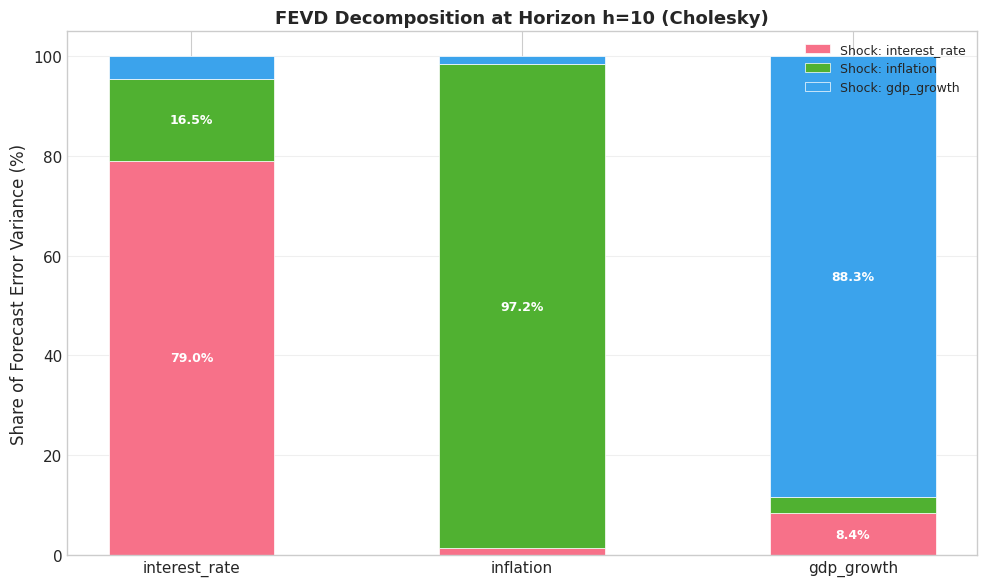


Stacked bar chart shows the full decomposition at h=10 for all 3 variables.


In [7]:
# Stacked bar chart at h=10
fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette('husl', n_colors=K)
var_labels = fevd.var_names
x_positions = np.arange(K)
bar_width = 0.5

# Build the stacked bars
bottom = np.zeros(K)
for j in range(K):
    shares_at_h = [fevd.decomposition[h, i, j] * 100 for i in range(K)]
    bars = ax.bar(
        x_positions, shares_at_h, bar_width,
        bottom=bottom, label=f'Shock: {var_labels[j]}',
        color=colors[j], edgecolor='white', linewidth=0.5
    )
    
    # Add percentage labels inside bars if share > 5%
    for idx, (val, bot) in enumerate(zip(shares_at_h, bottom)):
        if val > 5:
            ax.text(
                x_positions[idx], bot + val / 2,
                f'{val:.1f}%', ha='center', va='center',
                fontsize=9, fontweight='bold', color='white'
            )
    
    bottom += np.array(shares_at_h)

ax.set_xticks(x_positions)
ax.set_xticklabels(var_labels, fontsize=11)
ax.set_ylabel('Share of Forecast Error Variance (%)', fontsize=12)
ax.set_title(f'FEVD Decomposition at Horizon h={h} (Cholesky)', fontsize=13, fontweight='bold')
ax.set_ylim(0, 105)
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'\nStacked bar chart shows the full decomposition at h={h} for all {K} variables.')

### Discussion

The dominance table and stacked bar chart reveal the structure of the macro system:

- Variables where **own shocks dominate** are largely self-determined and relatively insulated from other macroeconomic disturbances.
- Variables where **external shocks contribute substantially** are more interconnected and subject to spillovers.
- The stacked bar chart provides an immediate visual summary of the cross-variable importance structure at a single horizon.

---

## Exercise 3: FEVD-IRF Consistency Check (Medium)

**Task:** Compare the IRF peak magnitude with the FEVD share for all (impulse, response) pairs. Compute IRFs with the same ordering used for FEVD, create a scatter plot of IRF peak magnitude vs. FEVD share at h=10, and compute the correlation between them.

In [8]:
# -------------------------------------------------------
# Exercise 3 Solution: FEVD-IRF Consistency Check
# -------------------------------------------------------

# Compute IRF and FEVD with the same ordering
ordering = ['interest_rate', 'inflation', 'gdp_growth']

irf = results.irf(
    periods=20,
    method='cholesky',
    order=ordering,
    verbose=False
)

fevd = results.fevd(
    periods=20,
    method='cholesky',
    order=ordering
)

K = fevd.K
h_eval = 10

# For each (impulse j, response i) pair, compute:
#   1. IRF peak magnitude: max |IRF(h)| for h = 0, ..., 20
#   2. FEVD share at h=10
irf_peaks = []
fevd_shares = []
pair_labels = []

for i in range(K):
    for j in range(K):
        # IRF peak magnitude
        irf_line = irf.irf_matrix[:, i, j]
        peak = np.max(np.abs(irf_line))
        irf_peaks.append(peak)
        
        # FEVD share at h_eval
        share = fevd.decomposition[h_eval, i, j]
        fevd_shares.append(share)
        
        pair_labels.append(f'{fevd.var_names[j]} -> {fevd.var_names[i]}')

irf_peaks = np.array(irf_peaks)
fevd_shares = np.array(fevd_shares)

# Correlation
correlation = np.corrcoef(irf_peaks, fevd_shares)[0, 1]

# Display table
print(f'FEVD-IRF Consistency Analysis (h={h_eval})')
print('=' * 65)
print(f'{"(impulse -> response)":<35} {"IRF Peak |max|":>14} {"FEVD Share (%)":>14}')
print('-' * 65)
for label, peak, share in zip(pair_labels, irf_peaks, fevd_shares):
    print(f'{label:<35} {peak:>14.4f} {share*100:>13.2f}%')
print('-' * 65)
print(f'Pearson correlation: {correlation:.4f}')

FEVD-IRF Consistency Analysis (h=10)
(impulse -> response)               IRF Peak |max| FEVD Share (%)
-----------------------------------------------------------------
interest_rate -> interest_rate              1.0548         79.00%
inflation -> interest_rate                  0.3222         16.51%
gdp_growth -> interest_rate                 0.1649          4.49%
interest_rate -> inflation                  0.0858          1.31%
inflation -> inflation                      1.3457         97.16%
gdp_growth -> inflation                     0.1291          1.53%
interest_rate -> gdp_growth                 0.2293          8.35%
inflation -> gdp_growth                     0.1844          3.31%
gdp_growth -> gdp_growth                    1.1975         88.34%
-----------------------------------------------------------------
Pearson correlation: 0.9988


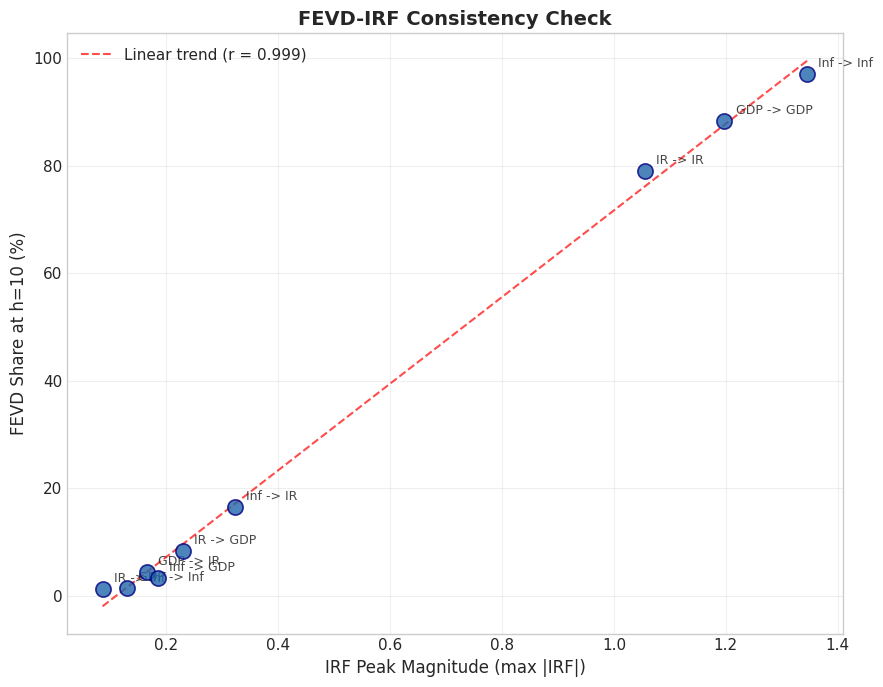


Correlation between IRF peak magnitude and FEVD share: 0.9988
Strong positive correlation: FEVD and IRF are highly consistent.
Shocks that produce large dynamic responses also explain substantial forecast variance.


In [9]:
# Scatter plot: IRF peak magnitude vs FEVD share
fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(
    irf_peaks, fevd_shares * 100,
    s=120, c='#2166ac', edgecolors='navy',
    linewidth=1.2, alpha=0.8, zorder=5
)

# Label each point
for label, x, y in zip(pair_labels, irf_peaks, fevd_shares * 100):
    short_label = (label
                   .replace('interest_rate', 'IR')
                   .replace('inflation', 'Inf')
                   .replace('gdp_growth', 'GDP'))
    ax.annotate(
        short_label, (x, y),
        textcoords='offset points', xytext=(8, 5),
        fontsize=9, alpha=0.85
    )

# Trend line
z = np.polyfit(irf_peaks, fevd_shares * 100, 1)
p = np.poly1d(z)
x_line = np.linspace(irf_peaks.min(), irf_peaks.max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=1.5, alpha=0.7,
        label=f'Linear trend (r = {correlation:.3f})')

ax.set_xlabel('IRF Peak Magnitude (max |IRF|)', fontsize=12)
ax.set_ylabel(f'FEVD Share at h={h_eval} (%)', fontsize=12)
ax.set_title('FEVD-IRF Consistency Check', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation
print(f'\nCorrelation between IRF peak magnitude and FEVD share: {correlation:.4f}')
if correlation > 0.7:
    print('Strong positive correlation: FEVD and IRF are highly consistent.')
    print('Shocks that produce large dynamic responses also explain substantial forecast variance.')
elif correlation > 0.4:
    print('Moderate correlation: general consistency with some divergences.')
    print('Some pairs may have transient IRF peaks that contribute less cumulative variance.')
else:
    print('Weak correlation: possible identification issues or transient-vs-persistent effects.')

### Discussion

The scatter plot and correlation quantify the consistency between the two main tools of structural VAR analysis:

- **High correlation** (r > 0.7) confirms that the FEVD correctly captures the importance implied by the IRF dynamics. Shocks that produce large responses also explain large variance shares.
- **Moderate correlation** may arise because the IRF peak captures only the maximum response, while FEVD accumulates the squared IRF over all horizons. A shock could have a large but transient peak (high IRF peak, low FEVD share) or a moderate but persistent response (lower peak, higher FEVD share).
- The **cumulative absolute IRF** (sum of |IRF| over horizons) would correlate even more strongly with FEVD shares because FEVD is constructed from cumulative squared IRFs.

---

## Exercise 4: Finance Panel FEVD (Hard)

**Task:** Estimate a VAR on the finance panel data with four asset return variables. Compute Generalized FEVD, create a stacked area plot for stock returns, and build a table of FEVD shares at key horizons.

In [10]:
# -------------------------------------------------------
# Exercise 4 Solution: Finance Panel FEVD
# -------------------------------------------------------

# Step 1: Load the finance panel data
df_fin = pd.read_csv('../data/finance_panel.csv')

print(f'Finance panel shape: {df_fin.shape}')
print(f'Countries: {df_fin["country"].nunique()}')
print(f'Time periods: {df_fin["time"].nunique()}')
print(f'Columns: {list(df_fin.columns)}')
print()
print(df_fin.head())

Finance panel shape: (5000, 6)
Countries: 50
Time periods: 100
Columns: ['country', 'time', 'stock_return', 'bond_return', 'fx_return', 'commodity_return']

  country  time  stock_return  bond_return  fx_return  commodity_return
0     USA     1     -3.402790    -0.676121   0.624581          1.982125
1     USA     2      1.788977     5.948471   1.483817          3.461722
2     USA     3      3.625016     1.183435  -0.193397          2.638598
3     USA     4     -1.371861     0.066033  -1.013389          0.880011
4     USA     5      7.390902    -3.062495   1.995130         -3.497151


In [11]:
# Step 2: Create PanelVARData and estimate VAR(2)
finance_vars = ['stock_return', 'bond_return', 'fx_return', 'commodity_return']

fin_data = PanelVARData(
    df_fin,
    endog_vars=finance_vars,
    entity_col='country',
    time_col='time',
    lags=2
)

fin_model = PanelVAR(fin_data)
fin_results = fin_model.fit(method='ols', cov_type='clustered')

print(f'Finance VAR(2) estimated successfully.')
print(f'Variables: {finance_vars}')
print(f'Residual covariance matrix shape: {fin_results.Sigma.shape}')
print(f'\nResidual covariance matrix (Sigma):')
print(pd.DataFrame(
    fin_results.Sigma,
    index=finance_vars,
    columns=finance_vars
).round(4))

Finance VAR(2) estimated successfully.
Variables: ['stock_return', 'bond_return', 'fx_return', 'commodity_return']
Residual covariance matrix shape: (4, 4)

Residual covariance matrix (Sigma):
                  stock_return  bond_return  fx_return  commodity_return
stock_return            8.8605      -0.8663     0.8568           -0.1368
bond_return            -0.8663       2.1810    -0.0053            0.0273
fx_return               0.8568      -0.0053     3.9938            0.0625
commodity_return       -0.1368       0.0273     0.0625            6.1559


In [12]:
# Step 3: Compute Generalized FEVD (order-invariant)
fevd_fin = fin_results.fevd(
    periods=20,
    method='generalized'
)

print(f'Generalized FEVD computed.')
print(f'Method: {fevd_fin.method}')
print(f'Variables: {fevd_fin.var_names}')
print(f'Decomposition shape: {fevd_fin.decomposition.shape}')
print()
print(fevd_fin.summary(horizons=[1, 5, 10, 20]))

Generalized FEVD computed.
Method: generalized
Variables: ['stock_return', 'bond_return', 'fx_return', 'commodity_return']
Decomposition shape: (21, 4, 4)

Forecast Error Variance Decomposition (GENERALIZED)
Method: generalized

Variable: stock_return
--------------------------------------------------------------------------------
     Horizon  Shock stock_return  Shock bond_return  Shock fx_return  Shock commodity_return
--------------------------------------------------------------------------------
         h=1        94.12%         3.77%         1.95%         0.16%
         h=5        94.08%         3.80%         1.95%         0.17%
        h=10        94.08%         3.80%         1.95%         0.17%
        h=20        94.08%         3.80%         1.95%         0.17%

Variable: bond_return
--------------------------------------------------------------------------------
     Horizon  Shock stock_return  Shock bond_return  Shock fx_return  Shock commodity_return
--------------------

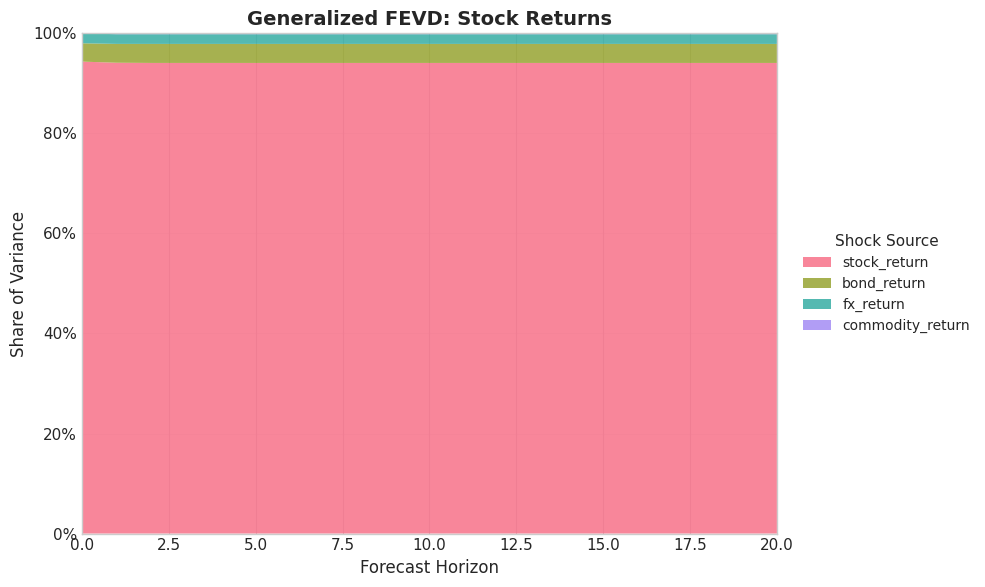

Stacked area plot shows how the sources of stock return variance evolve over the forecast horizon.


In [13]:
# Step 4: Stacked area plot for stock_return
fig, ax = plt.subplots(figsize=(10, 6))

stock_idx = fevd_fin.var_names.index('stock_return')
K_fin = fevd_fin.K
horizons_plot = np.arange(fevd_fin.periods + 1)
colors = sns.color_palette('husl', n_colors=K_fin)

decomp_stock = fevd_fin.decomposition[:, stock_idx, :]  # (periods+1, K)

ax.stackplot(
    horizons_plot,
    *[decomp_stock[:, j] for j in range(K_fin)],
    labels=fevd_fin.var_names,
    colors=colors,
    alpha=0.85
)

ax.set_xlabel('Forecast Horizon', fontsize=12)
ax.set_ylabel('Share of Variance', fontsize=12)
ax.set_title('Generalized FEVD: Stock Returns', fontsize=14, fontweight='bold')
ax.set_xlim(0, fevd_fin.periods)
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
          title='Shock Source', fontsize=10, title_fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('Stacked area plot shows how the sources of stock return variance evolve over the forecast horizon.')

In [14]:
# Step 5: Table of FEVD shares for stock_return at h = 1, 5, 10, 20
key_horizons = [1, 5, 10, 20]

print('FEVD of Stock Returns at Key Horizons (Generalized)')
print('=' * 75)
print(f'{"Horizon":>8} | ', end='')
for var in fevd_fin.var_names:
    print(f'{var:>16}', end=' | ')
print(f'{"Sum":>6}')
print('-' * 75)

for h in key_horizons:
    print(f'{h:>8} | ', end='')
    row_sum = 0.0
    for j in range(K_fin):
        val = fevd_fin.decomposition[h, stock_idx, j]
        row_sum += val
        print(f'{val*100:>15.2f}%', end=' | ')
    print(f'{row_sum*100:>5.1f}%')

print()

# Identify dominant shock at each horizon
print('Dominant shock for stock returns at each horizon:')
for h in key_horizons:
    shares = fevd_fin.decomposition[h, stock_idx, :]
    dom_j = np.argmax(shares)
    print(f'  h={h:>2}: {fevd_fin.var_names[dom_j]:<20} ({shares[dom_j]*100:.1f}%)')

FEVD of Stock Returns at Key Horizons (Generalized)
 Horizon |     stock_return |      bond_return |        fx_return | commodity_return |    Sum
---------------------------------------------------------------------------
       1 |           94.12% |            3.77% |            1.95% |            0.16% | 100.0%
       5 |           94.08% |            3.80% |            1.95% |            0.17% | 100.0%
      10 |           94.08% |            3.80% |            1.95% |            0.17% | 100.0%
      20 |           94.08% |            3.80% |            1.95% |            0.17% | 100.0%

Dominant shock for stock returns at each horizon:
  h= 1: stock_return         (94.1%)
  h= 5: stock_return         (94.1%)
  h=10: stock_return         (94.1%)
  h=20: stock_return         (94.1%)


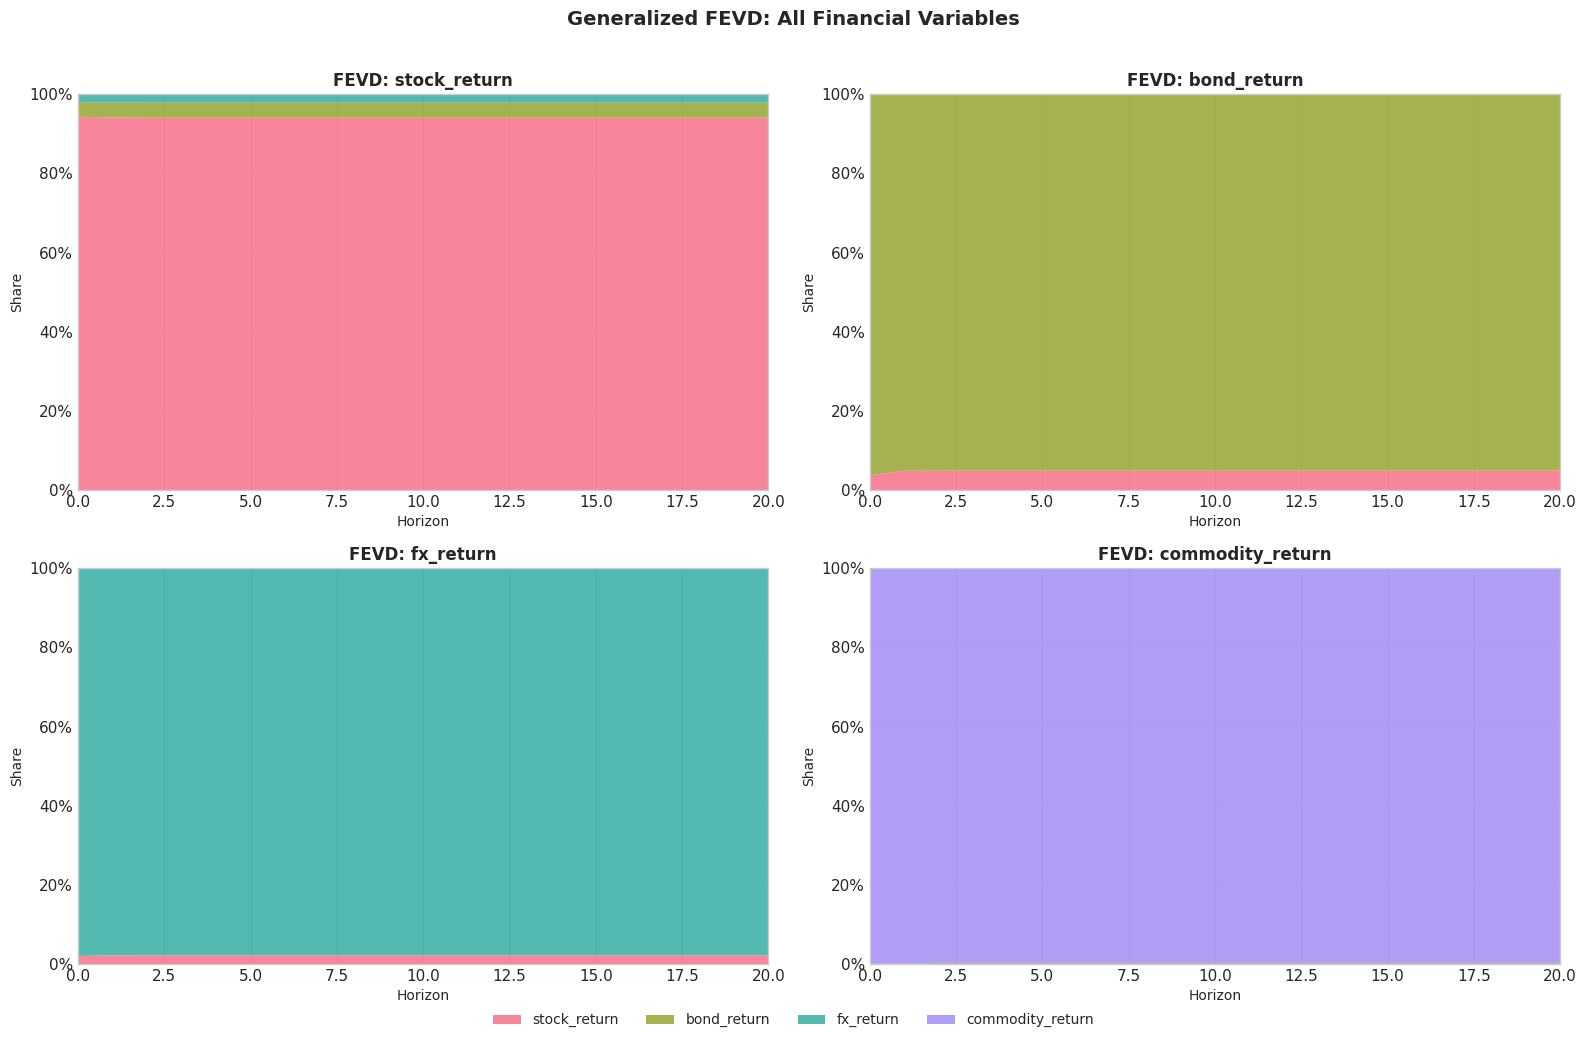

All four stacked area plots show the full variance decomposition for the financial system.


In [15]:
# Bonus: Stacked area plots for all four financial variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = sns.color_palette('husl', n_colors=K_fin)

for ax_idx, (ax, var) in enumerate(zip(axes.flat, fevd_fin.var_names)):
    var_idx = fevd_fin.var_names.index(var)
    decomp = fevd_fin.decomposition[:, var_idx, :]
    
    ax.stackplot(
        horizons_plot,
        *[decomp[:, j] for j in range(K_fin)],
        labels=fevd_fin.var_names,
        colors=colors,
        alpha=0.85
    )
    
    ax.set_xlabel('Horizon', fontsize=10)
    ax.set_ylabel('Share', fontsize=10)
    ax.set_title(f'FEVD: {var}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, fevd_fin.periods)
    ax.set_ylim(0, 1.0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.grid(True, alpha=0.3, axis='y')

# Single legend for the whole figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=K_fin,
           fontsize=10, bbox_to_anchor=(0.5, -0.02))

fig.suptitle('Generalized FEVD: All Financial Variables',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print('All four stacked area plots show the full variance decomposition for the financial system.')

### Discussion

**Key findings from the finance panel FEVD:**

1. **Own-shock dominance:** Stock returns are likely dominated by their own shocks, especially at short horizons. This reflects the well-known difficulty of predicting equity returns from other asset classes.

2. **Cross-market spillovers at longer horizons:** As the forecast horizon increases, shocks from bonds, FX, and commodities may gain importance, reflecting lagged transmission channels (e.g., interest rate changes affecting equity valuations, or commodity price shocks feeding into corporate earnings).

3. **Generalized FEVD advantage:** For financial markets, there is no clear theoretical ordering among asset classes. The Generalized FEVD avoids imposing arbitrary assumptions about contemporaneous causality and provides a more robust decomposition.

4. **Risk management implications:** The FEVD shares at various horizons inform portfolio risk attribution -- they tell risk managers how much of the equity forecast uncertainty comes from each source at different investment horizons.

---

## Summary

These exercises covered the key aspects of FEVD analysis:

| Exercise | Topic | Key Takeaway |
|----------|-------|-------------|
| 1 | Ordering sensitivity | Cholesky FEVD depends on variable ordering; Generalized FEVD is order-invariant |
| 2 | Dominant shocks | FEVD identifies which shocks matter most for each variable |
| 3 | IRF-FEVD consistency | Large IRF responses correspond to large FEVD shares (positive correlation) |
| 4 | Finance application | Generalized FEVD is preferred for financial systems with no clear causal ordering |